In [2]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, opening, area_closing)
from skimage.transform import resize
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd

Image Read and Denoise

In [3]:
def read_image(path):
    image = imread(path)
    if len(image.shape) > 2:
        return rgb2gray(image)
    return image

def bilateral_filter(image, diameter=15, sigma_color=75, sigma_space=75):
    print(image.max())
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space) / 255
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

def median_filter(image, kernel_size=3):
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.medianBlur(image, kernel_size) / 255
    return cv2.medianBlur(image, kernel_size)


def non_local_mean_filter(image, h=3):
    if image.max() != 255:
        image = image * 255
        image = image.astype('uint8')
        return cv2.fastNlMeansDenoising(image, h=h) / 255
    return cv2.fastNlMeansDenoising(image, h=h)

## Image thresholding and connected components

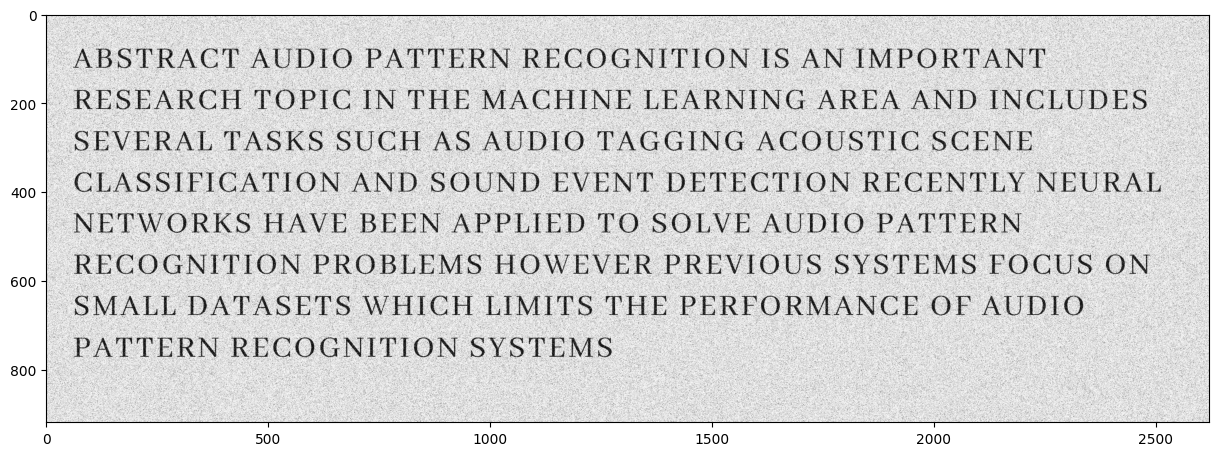

In [4]:
image_path = "../Data/test_images/noisy_three_sentences.jpg"
image = read_image(image_path)
plt.figure(figsize=(15,15))
plt.imshow(image,cmap="gray")
plt.show()
plt.close()


In [5]:
# plt.imshow(filtered_image_3, cmap="gray")
# plt.imshow(filtered_image_2, cmap="gray")

1.0


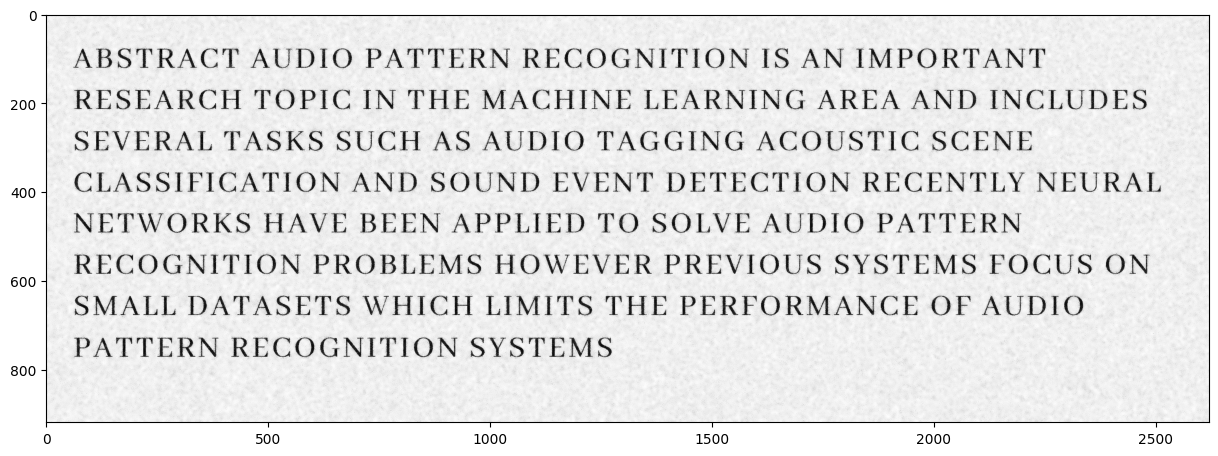

In [6]:
filtered_image = bilateral_filter(image, 10)
plt.figure(figsize=(15,15))
plt.imshow(filtered_image, cmap="gray")
plt.show()
plt.close()

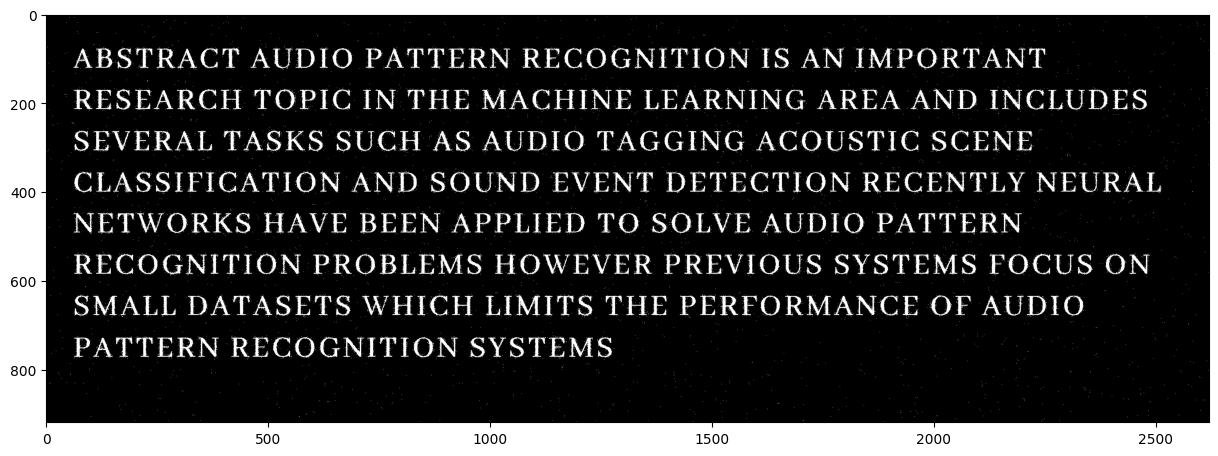

In [7]:
binarized_image = filtered_image < 0.75
plt.figure(figsize=(15,15))
plt.imshow(binarized_image, cmap="gray")
plt.show()
plt.close()

## Erosion, Dilation

In [247]:
square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])
                   
def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im

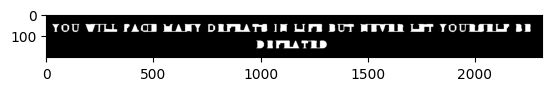

In [9]:
multi_dilated = multi_dil(binarized_image, 7)
area_closed = area_closing(multi_dilated, 5)
multi_eroded = multi_ero(area_closed, 7)
opened_image = opening(multi_eroded)
plt.imshow(opened_image, cmap="gray")

## Connected components

7735


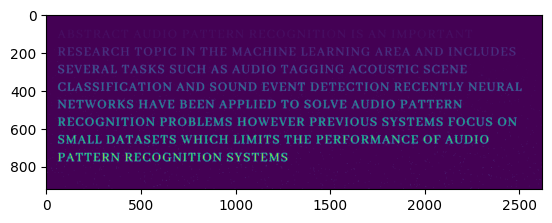

In [8]:
label_im = label(binarized_image)
regions = regionprops(label_im)
# regions = sorted(regions, key=lambda r: r.bbox[1])
print(len(regions))
plt.imshow(label_im)

In [65]:
# for lbl in np.unique(label_im):
#      # 0 would always be background
#      # print(lbl)
#      plt.imshow(label_im == lbl)
#      plt.show()

In [9]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation', 'centroid', 'bbox']
pd.DataFrame(regionprops_table(label_im, filtered_image, 
             properties=properties))

,area,convex_area,bbox_area,extent,mean_intensity,solidity,eccentricity,orientation,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3
0,2,2,4,0.5,0.684314,1.0,1.0,-0.785398,0.5,474.5,0,474,2,476
1,2,2,2,1.0,0.735294,1.0,1.0,0.000000,0.5,2022.0,0,2022,2,2023
2,1,1,1,1.0,0.745098,1.0,0.0,0.785398,1.0,1138.0,1,1138,2,1139
3,2,2,4,0.5,0.745098,1.0,1.0,0.785398,1.5,1222.5,1,1222,3,1224
4,2,2,2,1.0,0.735294,1.0,1.0,0.000000,1.5,1260.0,1,1260,3,1261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7730,1,1,1,1.0,0.674510,1.0,0.0,0.785398,916.0,2242.0,916,2242,917,2243
7731,1,1,1,1.0,0.701961,1.0,0.0,0.785398,917.0,1457.0,917,1457,918,1458
7732,1,1,1,1.0,0.737255,1.0,0.0,0.785398,918.0,842.0,918,842,919,843
7733,1,1,1,1.0,0.705882,1.0,0.0,0.785398,918.0,1196.0,918,1196,919,1197


In [10]:
masks = []
bbox = []
list_of_index = []
remove_nums = []
for num, x in enumerate(regions):
    area = x.area
    convex_area = x.convex_area
    
    if (convex_area/area >0.95) and area>275:
        print(num, area, convex_area, x.bbox, x.centroid)
        masks.append(regions[num].convex_image)
        bbox.append(regions[num].bbox)   
        list_of_index.append(num)
    else:
        # print(num)
        remove_nums.append(num)
for i in sorted(remove_nums, reverse=True):
    del regions[i]
count = len(masks)
print(count, len(regions))

222 625 1631 (75, 1485, 122, 1528) (98.7456, 1506.4272)
230 639 1649 (75, 1962, 124, 2007) (99.12363067292645, 1983.6917057902974)
234 638 1949 (75, 2161, 122, 2207) (98.71003134796238, 2182.824451410658)
236 704 1492 (76, 113, 121, 150) (98.97301136363636, 130.6150568181818)
238 545 1324 (76, 160, 123, 192) (99.35229357798165, 176.1834862385321)
241 502 1379 (76, 203, 123, 240) (94.35258964143426, 220.89442231075697)
245 493 1543 (76, 347, 122, 387) (98.97565922920893, 364.4503042596349)
246 525 1426 (76, 397, 123, 436) (94.04571428571428, 415.687619047619)
248 489 1111 (76, 763, 122, 806) (101.92842535787321, 785.8650306748466)
252 510 1373 (76, 860, 122, 898) (94.46274509803922, 878.0588235294117)
255 522 1567 (76, 906, 124, 941) (99.14176245210729, 922.3773946360153)
264 608 1715 (76, 1273, 123, 1318) (100.09210526315789, 1293.421052631579)
272 571 1378 (76, 1641, 123, 1674) (99.21716287215412, 1656.9737302977233)
277 496 1385 (76, 2065, 122, 2104) (94.35887096774194, 2084.0625)
27

In [11]:
def re_arrange_letters(bbox, regions, limit=5):
    x_mins = list([str(box[0]) for box in bbox])
    print(x_mins)
    for x_min in x_mins:
        for i in range(1,limit):
            if str(int(x_min)+i) in x_mins:
                x_mins = list(map(lambda x: x.replace(str(int(x_min)+i), x_min), x_mins))
    x_mins = [int(x_min) for x_min in x_mins]
    for x_min, box in zip(x_mins, bbox):
        box = (x_min, box[1], box[2], box[3])
    x_mins.append(max(x_mins) + 1)
    unique_x_mins = sorted(list(set(x_mins)))
    print(unique_x_mins)
    line_bbox, line_regions = [], []
    for index, unique_x_min in enumerate(unique_x_mins):
        if index==0:
            start = x_mins.index(unique_x_min)
            continue
        end = x_mins.index(unique_x_min)
        print(x_mins[start:end])
        line_bbox.append(bbox[start:end])
        line_regions.append(regions[start:end])
        # print(regions[start:end], bbox[start:end])
        start = end
    # print(line_regions)
    new_bbox, new_masks, new_regions = [], [], []
    for line_box, line_region in zip(line_bbox, line_regions):
        # print("Before")
        # [print(r.bbox) for r in line_region]
        line_region = sorted(line_region, key=lambda r: r.bbox[1])
        # print("After")
        # [print(r.bbox) for r in line_region]
        line_box = sorted(line_box, key=lambda x: x[1])
        # print(line_box)
        new_mask = [region.convex_image for region in line_region]
        new_masks.extend(new_mask)
        new_bbox.extend(line_box)
        new_regions.extend(line_region)
    return new_bbox, new_masks, new_regions


['75', '75', '75', '76', '76', '76', '76', '76', '76', '76', '76', '76', '76', '76', '76', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '78', '78', '78', '78', '78', '78', '78', '78', '168', '169', '169', '169', '169', '169', '169', '169', '169', '169', '169', '169', '169', '169', '169', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '170', '171', '171', '171', '171', '171', '171', '171', '171', '171', '171', '171', '172', '261', '261', '261', '262', '262', '262', '262', '262', '262', '262', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '263', '264', '264', '264', '264', '264', '264', '264', '264', '264', '264', '354', '354', '354', '355', '355', '355', '355', '355', '355', '355', '355', '356', '356', '356', 

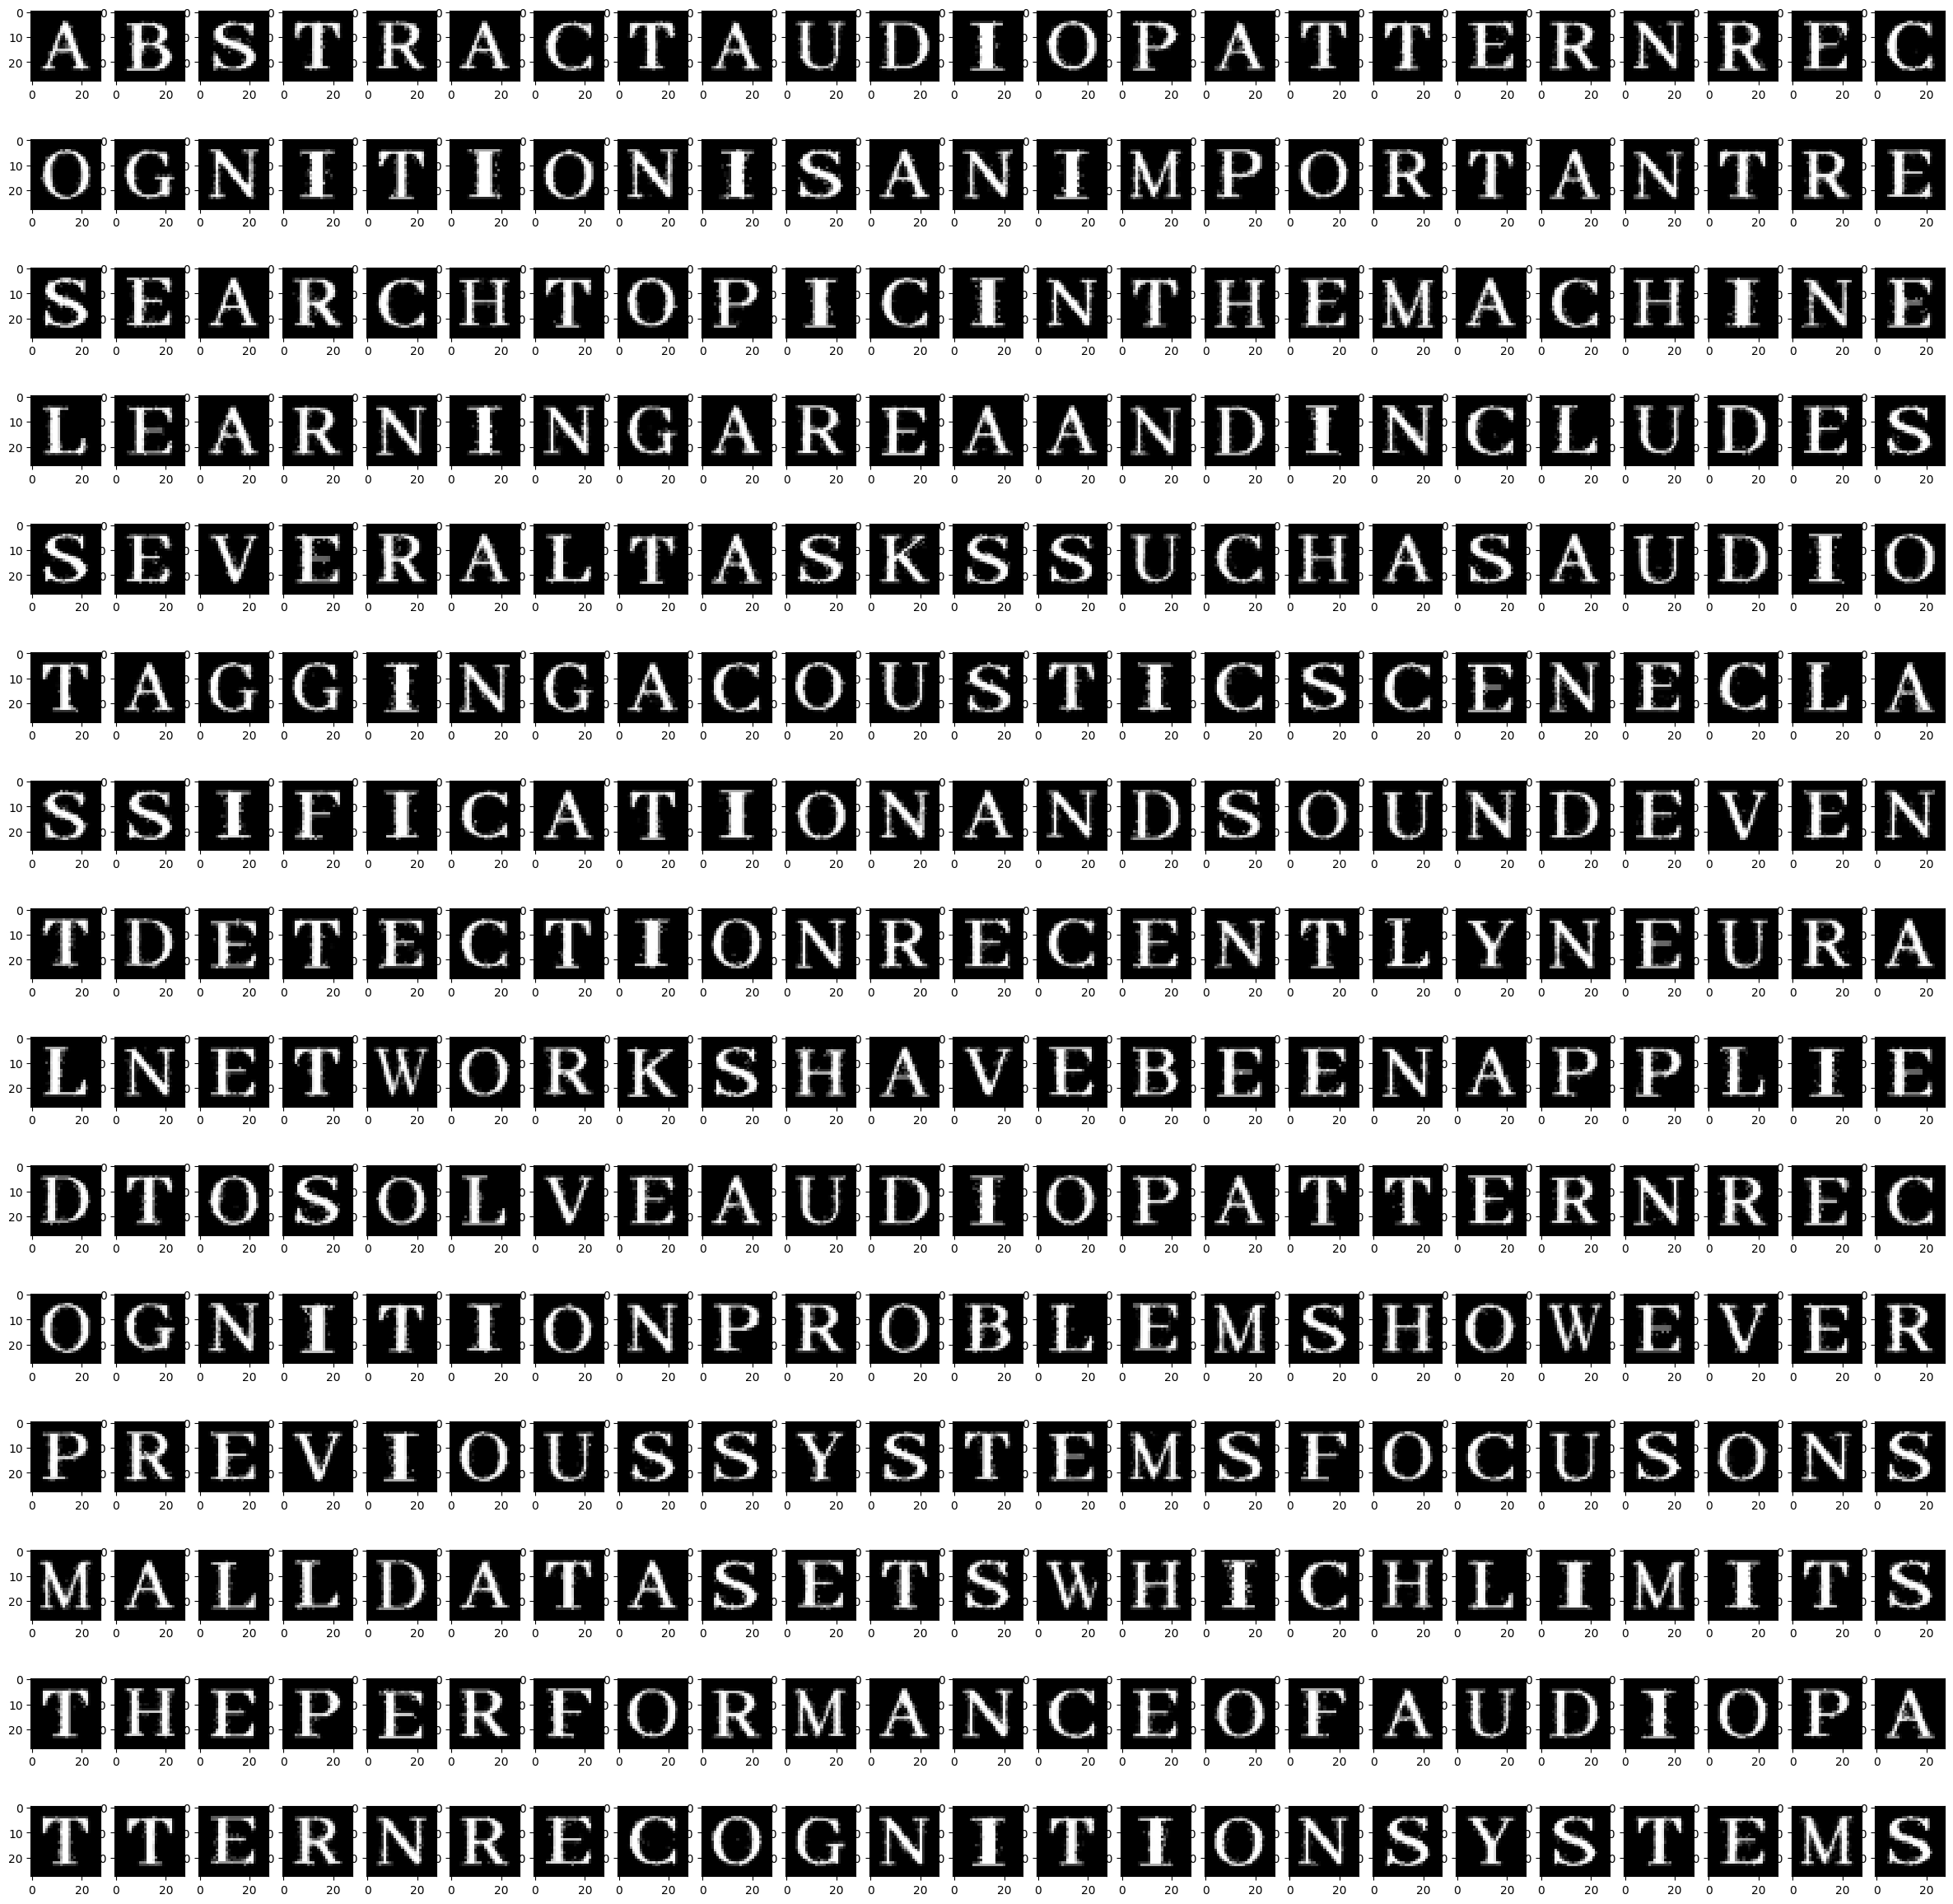

In [12]:
fig, ax = plt.subplots(15, int(count/15), figsize=(30,30))
bounded_images = []
bbox, masks, regions = re_arrange_letters(bbox, regions)
print(len(masks))
for index, (axis, box, mask) in enumerate(zip(ax.flatten(), bbox, masks)):
    
    bounded_image  =  binarized_image[box[0]:box[2], box[1]:box[3]] * mask
    bounded_image = np.pad(bounded_image, pad_width=10)
    bounded_image = bilateral_filter(bounded_image)
    bounded_image = resize(bounded_image, (28, 28))
    # plt.imshow(bounded_image)
    # plt.savefig(f"../Data/test_images/msg_from_annie_{index}.png")
    bounded_images.append(bounded_image)
    axis.imshow(bounded_image, cmap="gray")


## Model Predict

In [13]:
from predict import CharacterPredictor

predictor = CharacterPredictor(model_path="../Data/model.pth")
output_filename = image_path.replace(".jpg", "_predicted.txt")
output_file = open(output_filename, "w")
for bounded_image in bounded_images:
    prediction = predictor.predict(bounded_image)
    print(prediction)
    output_file.write(prediction)
output_file.close()

/home/sci/zahid.aziz/miniconda3/envs/image2ssm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


A
B
S
R
K
A
C
T
A
U
U
I
O
P
A
R
T
E
R
N
R
E
C
O
C
N
I
T
X
O
N
X
S
A
N
I
M
P
O
R
T
A
N
R
R
E
S
E
A
R
C
H
T
O
P
I
C
I
N
R
U
E
M
A
C
H
X
N
B
X
E
A
R
N
I
N
C
A
R
E
A
A
N
D
I
N
C
L
U
D
E
S
S
B
V
E
R
A
L
R
A
S
K
S
S
U
C
H
A
S
A
U
D
I
O
R
A
C
G
X
N
G
A
C
O
U
S
R
I
C
S
C
E
N
E
C
L
A
S
S
I
R
I
C
A
T
I
O
N
A
N
D
S
O
U
N
D
E
V
E
N
T
U
E
T
E
C
T
I
O
N
K
E
C
E
N
T
L
Y
N
E
U
K
A
L
N
L
R
W
O
R
K
S
H
A
V
E
B
E
E
N
A
P
P
L
I
E
D
R
O
S
O
L
V
E
A
U
D
I
O
P
A
T
T
E
K
N
R
E
C
O
G
N
X
T
I
O
N
R
R
O
B
X
L
M
S
H
O
W
D
V
E
R
P
R
E
V
I
O
U
S
S
Y
S
R
E
M
S
R
O
C
U
S
O
N
S
M
A
L
N
U
A
R
D
S
E
R
S
W
H
I
C
H
L
X
M
X
T
S
R
H
E
R
E
K
R
O
R
M
A
N
C
E
O
R
A
U
D
I
O
P
A
R
T
L
R
N
R
E
C
O
C
N
X
R
I
O
N
S
Y
S
T
E
M
S


In [16]:
def compare_with_gt(gt_filename, predicted_filename):
    print(gt_filename)
    gt_file = open(gt_filename, "r")
    predicted_file = open(predicted_filename, "r")
    gt_line = gt_file.readline().strip()
    print(gt_line)
    predicted_line = predicted_file.readline().strip()
    count = 0
    for gt, predicted in zip(gt_line, predicted_line):
        print(gt, predicted)
        if predicted == gt.upper():
            count+=1
    gt_file.close()
    predicted_file.close()
    return count/len(gt_line)

In [17]:
compare_with_gt(gt_filename="/home/sci/zahid.aziz/Desktop/Projects/CS-6640-Image-Processing/project_5/Data/test_images/three_sentences_gt.txt", 
                predicted_filename= output_filename)

/home/sci/zahid.aziz/Desktop/Projects/CS-6640-Image-Processing/project_5/Data/test_images/three_sentences_gt.txt
AbstractAudiopatternrecognitionisanimportantresearchtopicinthemachinelearningareaandincludesseveraltaskssuchasaudiotaggingacousticsceneclassificationandsoundeventdetectionRecentlyneuralnetworkshavebeenappliedtosolveaudiopatternrecognitionproblemsHoweverprevioussystemsfocusonsmalldatasetswhichlimitstheperformanceofaudiopatternrecognitionsystems
A A
b B
s S
t R
r K
a A
c C
t T
A A
u U
d U
i I
o O
p P
a A
t R
t T
e E
r R
n N
r R
e E
c C
o O
g C
n N
i I
t T
i X
o O
n N
i X
s S
a A
n N
i I
m M
p P
o O
r R
t T
a A
n N
t R
r R
e E
s S
e E
a A
r R
c C
h H
t T
o O
p P
i I
c C
i I
n N
t R
h U
e E
m M
a A
c C
h H
i X
n N
e B
l X
e E
a A
r R
n N
i I
n N
g C
a A
r R
e E
a A
a A
n N
d D
i I
n N
c C
l L
u U
d D
e E
s S
s S
e B
v V
e E
r R
a A
l L
t R
a A
s S
k K
s S
s S
u U
c C
h H
a A
s S
a A
u U
d D
i I
o O
t R
a A
g C
g G
i X
n N
g G
a A
c C
o O
u U
s S
t R
i I
c C
s S
c C
e E
n N
e E
c

0.8492753623188406